In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
d["height"].mean()

154.5970926136364

In [4]:
d["height"].std()

7.742332137351995

# Prior predictive checks

In [37]:
model_ppc=CmdStanModel(stan_file='height_1_pcc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,
                     refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [38]:
df = sim.draws_pd()
df

,lp__,accept_stat__,mu,sigma,height
0,0.0,0.0,183.541,15.7772,163.468
1,0.0,0.0,170.638,13.6106,173.988
2,0.0,0.0,175.994,17.2653,192.756
3,0.0,0.0,172.777,15.5989,172.433
4,0.0,0.0,176.560,14.6579,172.000
...,...,...,...,...,...
995,0.0,0.0,169.864,15.5211,182.043
996,0.0,0.0,167.970,13.8066,171.750
997,0.0,0.0,166.817,14.8988,167.878
998,0.0,0.0,170.046,15.2480,146.768


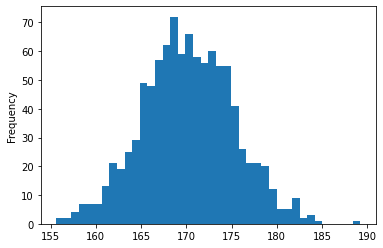

In [39]:
df['mu'].plot.hist(bins=40)
plt.show()

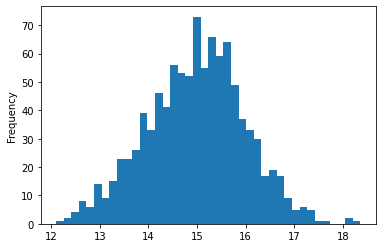

In [40]:
df['sigma'].plot.hist(bins=40)
plt.show()

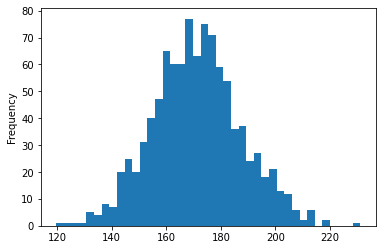

In [41]:
df['height'].plot.hist(bins=40)
plt.show()

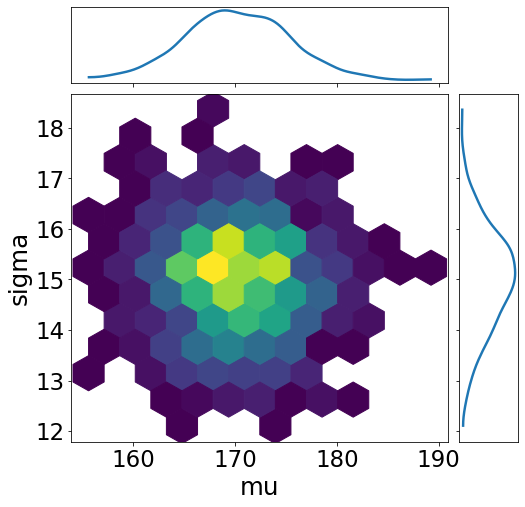

In [42]:
az.plot_pair(
    sim,
    var_names=["mu", "sigma"],
    kind="hexbin",
    marginals=True,
    figsize=(8, 8),
)
plt.show()

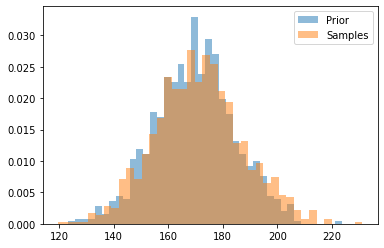

In [43]:
prior = np.random.normal(170, 15, R)
fig, ax = plt.subplots()
ax.hist(prior, bins=40, alpha=0.5, density=True, label='Prior')
ax.hist(df['height'], bins=40, alpha=0.5, density=True, label='Samples')
ax.legend()
plt.show()

In [44]:
df["height"].mean()

171.24215999999998

In [45]:
df["height"].std()

16.151664194895357

### Samples are consistent with priors and observed data is possible to obtain using prior.
<br><br>

# Model fit and evaluation

In [46]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [47]:
fit=model_1_fit.sample(data=dict(N=len(d), heights=d.height.values), seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [48]:
df = fit.draws_pd()
df

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,heights_pred
0,-925.039,0.997516,0.851161,2.0,3.0,0.0,926.836,154.463,8.61784,144.608
1,-925.152,0.883637,0.851161,1.0,3.0,0.0,926.452,155.103,8.31445,152.507
2,-925.081,0.914748,0.851161,3.0,7.0,0.0,926.221,154.393,8.27846,155.496
3,-927.291,0.744238,0.851161,2.0,3.0,0.0,928.160,153.713,8.37281,159.604
4,-927.026,1.000000,0.851161,2.0,7.0,0.0,927.318,155.682,8.43007,162.645
...,...,...,...,...,...,...,...,...,...,...
3995,-925.162,0.894975,0.958162,2.0,3.0,0.0,926.311,155.116,8.33014,166.062
3996,-925.240,0.833705,0.958162,1.0,3.0,0.0,926.500,154.288,8.54380,155.836
3997,-925.339,0.988741,0.958162,2.0,7.0,0.0,925.740,154.769,8.05847,158.499
3998,-925.396,0.995165,0.958162,2.0,3.0,0.0,925.525,154.799,8.04573,172.279


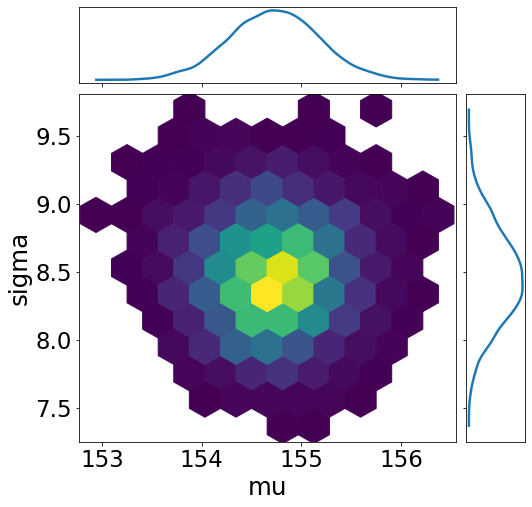

In [49]:
az.plot_pair(
    fit,
    var_names=["mu", "sigma"],
    kind="hexbin",
    marginals=True,
    figsize=(8, 8),
)
plt.show()

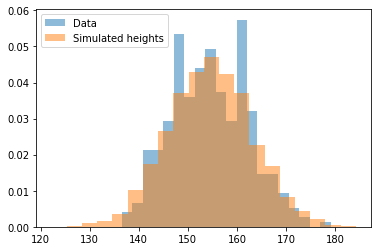

In [54]:
fig, ax = plt.subplots()
ax.hist(d["height"], bins=20, alpha=0.5, density=True, label='Data')
ax.hist(df['heights_pred'], bins=20, alpha=0.5, density=True, label='Simulated heights')
ax.legend()
plt.show()

In [61]:
df['heights_pred'].mean()

154.65829725

In [62]:
df['heights_pred'].std()

7.773388699457955

Model fit to data, it's mean and std are consistent with data, but the data distribution looks a bit different. <br><br>

# Adding predictor to the model - weight

In [64]:
data_sim={'N':50, 'weight':np.linspace(d.weight.min(),d.weight.max())}

# Prior predictive checks

In [105]:
model_ppc=CmdStanModel(stan_file='height_2a_pcc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /home/lab_3/height_2a_pcc.stan to exe file /home/lab_3/height_2a_pcc
INFO:cmdstanpy:compiled model executable: /home/lab_3/height_2a_pcc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/lab_3/height_2a_pcc.hpp /home/lab_3/height_2a_pcc.stan
Warning in '/home/lab_3/height_2a_pcc.stan', line 3, column 3: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/lab_3/height_2a_pcc.stan', line 17, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare 


INFO:cmdstanpy:CmdStan done processing.


In [106]:
df = sim.draws_pd()
df

,lp__,accept_stat__,mu,sigma,alpha,betha,height[1],height[2],height[3],height[4],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,197.082,7.45546,177.772,0.127591,171.377,183.655,190.840,198.875,...,199.098,196.621,187.165,175.003,181.379,183.448,191.254,187.770,190.5250,176.8710
1,0.0,0.0,169.932,12.42970,169.963,0.759566,202.758,208.702,209.633,204.871,...,202.168,211.902,202.505,221.249,202.394,214.590,232.539,215.877,212.0080,203.6570
2,0.0,0.0,157.781,9.62357,184.165,-0.160307,185.008,182.871,187.470,158.407,...,178.242,193.747,174.893,184.269,178.910,174.101,176.434,164.824,171.7220,169.1790
3,0.0,0.0,183.290,9.56433,163.402,-0.953380,131.669,142.324,139.249,140.956,...,104.730,103.731,116.232,102.493,110.332,102.422,95.708,120.571,97.2461,78.3807
4,0.0,0.0,164.086,8.45239,162.161,1.294470,209.349,207.795,215.774,209.078,...,232.303,232.467,244.206,243.507,232.608,234.276,226.201,234.324,235.9730,227.6410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,182.373,10.22330,158.401,-0.540070,146.180,139.708,134.651,151.954,...,130.876,124.034,116.698,110.079,116.537,130.573,132.873,125.112,115.0080,125.9140
996,0.0,0.0,176.097,10.63550,161.940,0.413004,166.239,177.241,177.756,181.389,...,175.462,191.103,194.920,191.350,188.418,168.269,177.957,202.230,211.4510,179.9860
997,0.0,0.0,177.781,11.71380,159.138,-0.398881,151.649,139.843,143.580,155.282,...,148.167,132.267,131.251,134.509,100.007,148.481,128.955,115.540,138.2440,118.4560
998,0.0,0.0,172.442,10.92780,171.996,-0.163164,167.028,156.784,171.549,164.999,...,143.410,169.025,161.221,171.141,159.162,162.274,149.406,164.905,156.8970,170.5310


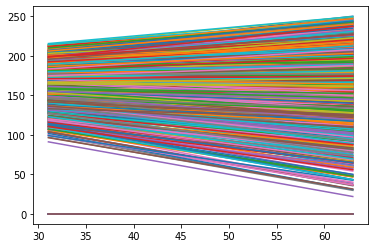

In [107]:
alpha = df['alpha']
beta = df['betha']
height = df['height[1]']

for i in range(len(alpha)):
    x_axis = np.linspace(min(d.weight), max(d.weight), len(alpha))
    y = alpha[i] + beta[i] * x_axis
    plt.plot(x_axis, y)

# Modifying prior

In [111]:
model_ppc=CmdStanModel(stan_file='height_2b_pcc.stan')

INFO:cmdstanpy:compiling stan file /home/lab_3/height_2b_pcc.stan to exe file /home/lab_3/height_2b_pcc
INFO:cmdstanpy:compiled model executable: /home/lab_3/height_2b_pcc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/lab_3/height_2b_pcc.hpp /home/lab_3/height_2b_pcc.stan
Warning in '/home/lab_3/height_2b_pcc.stan', line 3, column 3: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/lab_3/height_2b_pcc.stan', line 17, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare 

In [112]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


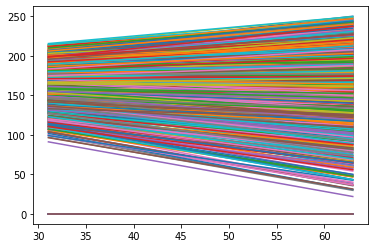

In [113]:
alpha = df['alpha']
beta = df['betha']
height = df['height[1]']

for i in range(len(alpha)):
    x_axis = np.linspace(min(d.weight), max(d.weight), len(alpha))
    y = alpha[i] + beta[i] * x_axis
    plt.plot(x_axis, y)